# Analyse des Données de Cryptomonnaies
Ce notebook contient une analyse détaillée des données récupérées à partir de l'API Binance pour les 10 principales paires USDT.

Les étapes incluent l'exploration, la visualisation et la préparation des données pour un tableau de bord interactif.

In [45]:

# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mplfinance as mpf
import networkx as nx

# Configurer les graphiques pour affichage
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


# General Summary of All Datasets

In [46]:
# Define the folder path
data_folder = "data/binance"

# List all CSV files in the folder
csv_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_folder) for f in filenames if f.endswith('.csv')]

# Summarize all CSV files
for csv_file in csv_files:
    print(f"Summary for {csv_file}")
    df = pd.read_csv(csv_file)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Data Types:\n{df.dtypes}")
    print("\n")

Summary for data/binance/top_10_usdt_pairs_with_info.csv
Shape: (10, 14)
Columns: ['Symbol', 'Score', 'Volume', 'Price', 'Status', 'Base Asset', 'Quote Asset', 'Min Price', 'Max Price', 'Tick Size', 'Min Qty', 'Max Qty', 'Step Size', 'Min Notional']
Data Types:
Symbol           object
Score           float64
Volume          float64
Price           float64
Status           object
Base Asset       object
Quote Asset      object
Min Price       float64
Max Price       float64
Tick Size       float64
Min Qty         float64
Max Qty         float64
Step Size       float64
Min Notional    float64
dtype: object


Summary for data/binance/top_10_fees.csv
Shape: (10, 3)
Columns: ['Symbol', 'Maker Fee', 'Taker Fee']
Data Types:
Symbol        object
Maker Fee    float64
Taker Fee    float64
dtype: object


Summary for data/binance/top_10_funding_rates.csv
Shape: (8, 3)
Columns: ['Symbol', 'Funding Rate', 'Funding Time']
Data Types:
Symbol           object
Funding Rate    float64
Funding Time     

Shape: (525600, 6)
Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
Data Types:
Timestamp      int64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object


Summary for data/binance/top_10_kline_granular/BTCUSDT_1h_kline.csv
Shape: (8760, 6)
Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
Data Types:
Timestamp      int64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object


Summary for data/binance/top_10_kline_granular/BNBUSDT_1h_kline.csv
Shape: (8760, 6)
Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
Data Types:
Timestamp      int64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object


Summary for data/binance/top_10_kline_granular/WBETHUSDT_1m_kline.csv
Shape: (525600, 6)
Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']


## Chargement des Données
Chargement les fichiers CSV contenant les données collectées pour an analyse initiale.

In [47]:

# Chargement des fichiers CSV
top_10_info = pd.read_csv("data/binance/top_10_usdt_pairs_with_info.csv")
fees = pd.read_csv("data/binance/top_10_fees.csv")
funding_rates = pd.read_csv("data/binance/top_10_funding_rates.csv")
exchange_stats = pd.read_csv("data/binance/top_10_exchange_stats.csv")
futures_data = pd.read_csv("data/binance/top_10_futures_data.csv")
correlation_matrix = pd.read_csv("data/binance/top_10_correlation_matrix.csv", index_col=0)
real_time_data = pd.read_csv("data/binance/top_10_real_time.csv")
order_book = pd.read_csv("data/binance/top_10_order_books/BTCUSDT_order_book.csv")
aggregated_trades = pd.read_csv('data/binance/top_10_aggregated_trades/BTCUSDT_aggregated_trades.csv')
btc_kline = pd.read_csv("data/binance/top_10_kline_granular/BTCUSDT_1m_kline.csv")
btc_historical = pd.read_csv("data/binance/top_10/BTCUSDT_history_last_year.csv")

## Aperçu des Données
Un aperçu des datasets pour comprendre leur structure.

In [48]:

# Aperçu des données
print("Top 10 Infos :")
print(top_10_info.head())

print("Fees :")
print(fees.head())

print("Funding Rates :")
print(funding_rates.head())

print("Exchange Stats :")
print(exchange_stats.head())


Top 10 Infos :
     Symbol         Score        Volume     Price   Status Base Asset  \
0   BTCUSDT  7.610026e+13  7.774957e+08  97878.70  TRADING        BTC   
1   ETHUSDT  2.493976e+12  6.883047e+08   3623.36  TRADING        ETH   
2  WBTCUSDT  4.257589e+11  4.360425e+06  97641.62  TRADING       WBTC   
3   SOLUSDT  9.599306e+10  4.500378e+08    213.30  TRADING        SOL   
4   BNBUSDT  6.732070e+10  9.516773e+07    707.39  TRADING        BNB   

  Quote Asset  Min Price  Max Price  Tick Size  Min Qty   Max Qty  Step Size  \
0        USDT       0.01  1000000.0       0.01  0.00001    9000.0    0.00001   
1        USDT       0.01  1000000.0       0.01  0.00010    9000.0    0.00010   
2        USDT       0.01  1000000.0       0.01  0.00001    9000.0    0.00001   
3        USDT       0.01    10000.0       0.01  0.00100   90000.0    0.00100   
4        USDT       0.01   100000.0       0.01  0.00100  900000.0    0.00100   

   Min Notional  
0           NaN  
1           NaN  
2          

## Analyse des Variations des Prix (Top Movers)
Identification des paires ayant les plus grandes variations de prix.

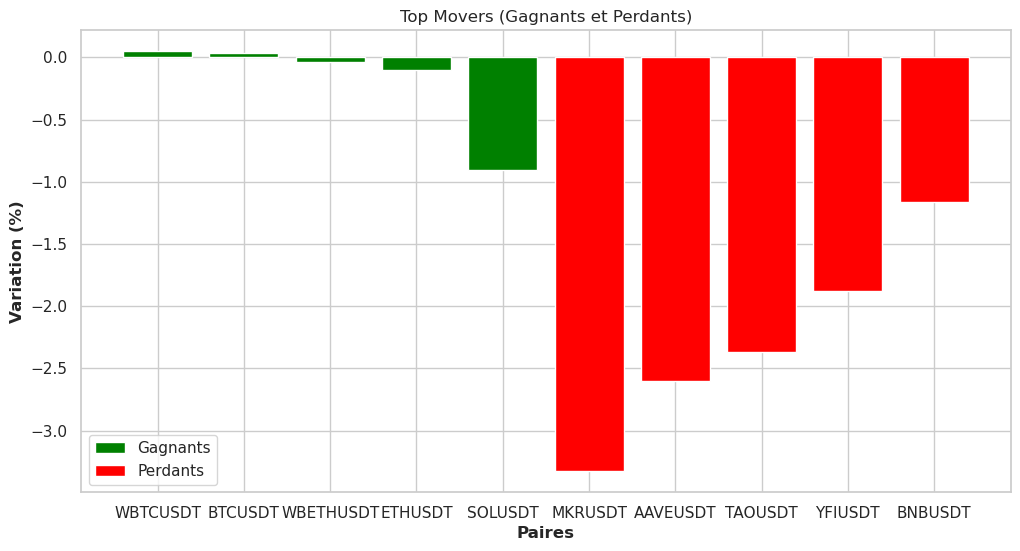

In [49]:

# Calcul des variations en pourcentage
exchange_stats['Price Change (%)'] = exchange_stats['Price Change (%)'].astype(float)
top_gainers = exchange_stats.nlargest(5, 'Price Change (%)')
top_losers = exchange_stats.nsmallest(5, 'Price Change (%)')

# Visualisation
plt.bar(top_gainers['Symbol'], top_gainers['Price Change (%)'], color='green', label='Gagnants')
plt.bar(top_losers['Symbol'], top_losers['Price Change (%)'], color='red', label='Perdants')
plt.title("Top Movers (Gagnants et Perdants)")
plt.xlabel("Paires")
plt.ylabel("Variation (%)")
plt.legend()
plt.show()


## Analyse de la Liquidité
Analyse de la profondeur du carnet d'ordres pour les paires avec les meilleures liquidités.

Moyenne des spreads pour BTCUSDT : 0.10623115577889154


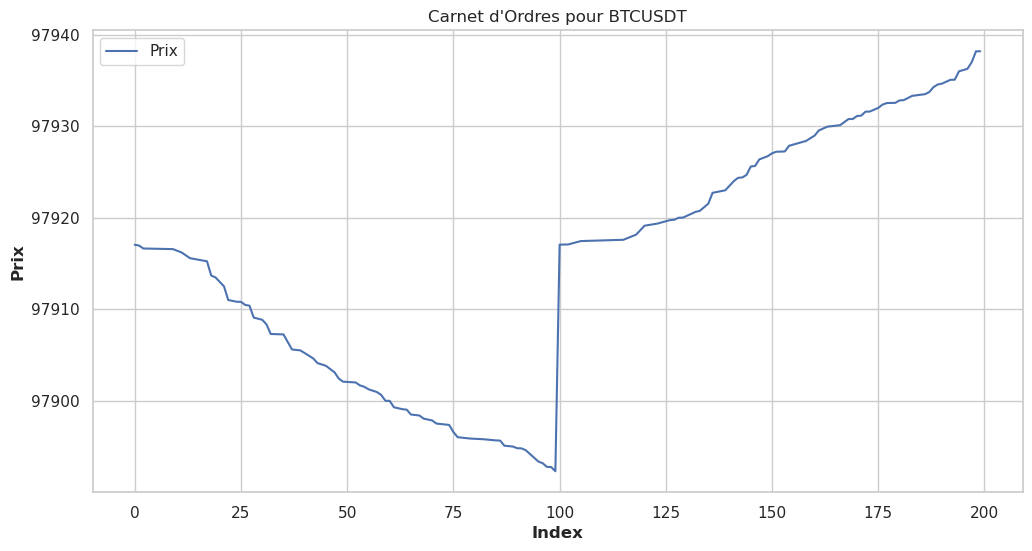

In [50]:

# Calcul de la moyenne des spreads bid-ask
order_book['Spread'] = order_book['Price'].diff()
average_spread = order_book['Spread'].mean()
print(f"Moyenne des spreads pour BTCUSDT : {average_spread}")

# Visualisation du carnet d'ordres
plt.plot(order_book['Price'], label='Prix')
plt.title("Carnet d'Ordres pour BTCUSDT")
plt.xlabel("Index")
plt.ylabel("Prix")
plt.legend()
plt.show()


# Analyse des paires de trading USDT

In [51]:
# Convertir les timestamps en dates lisibles
def convert_timestamp(df, column):
    df[column] = pd.to_datetime(df[column], unit='ms')

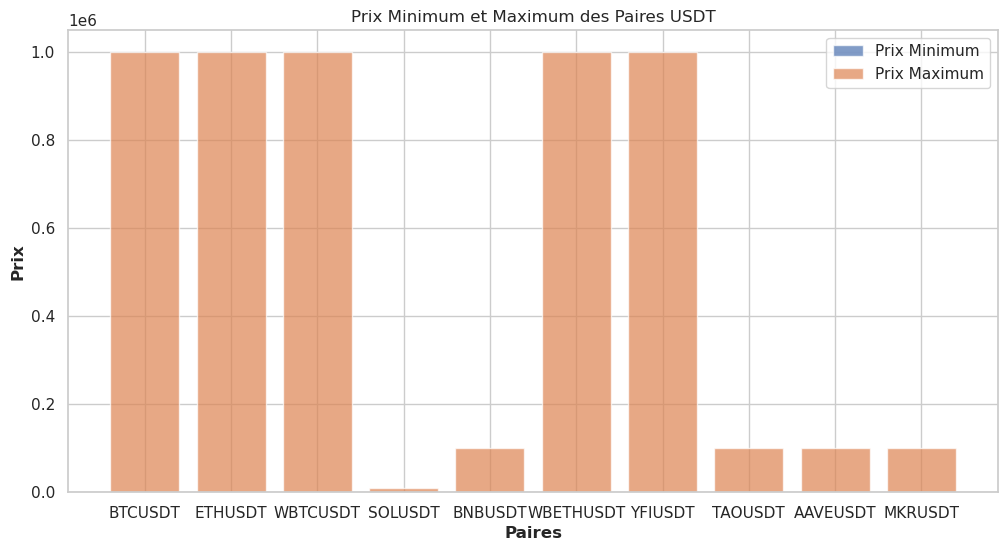

In [52]:

# Visualisation des prix minimums et maximums par paire
plt.figure(figsize=(12, 6))
plt.bar(top_10_info['Symbol'], top_10_info['Min Price'], label='Prix Minimum', alpha=0.7)
plt.bar(top_10_info['Symbol'], top_10_info['Max Price'], label='Prix Maximum', alpha=0.7)
plt.title("Prix Minimum et Maximum des Paires USDT")
plt.xlabel("Paires")
plt.ylabel("Prix")
plt.legend()
plt.show()

# Analyse des frais de transaction

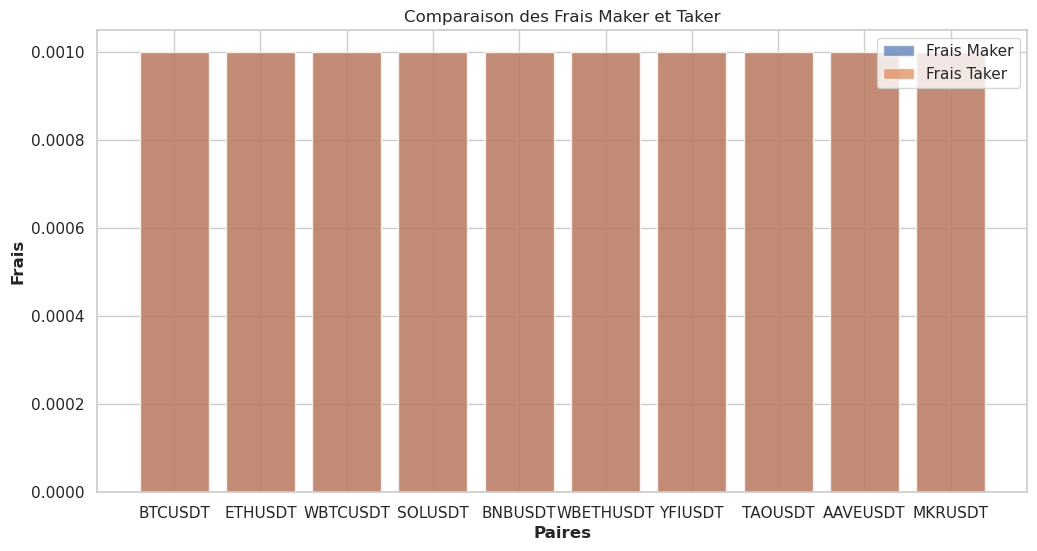

In [53]:
# Visualisation des frais Maker et Taker
plt.figure(figsize=(12, 6))
plt.bar(fees['Symbol'], fees['Maker Fee'], label='Frais Maker', alpha=0.7)
plt.bar(fees['Symbol'], fees['Taker Fee'], label='Frais Taker', alpha=0.7)
plt.title("Comparaison des Frais Maker et Taker")
plt.xlabel("Paires")
plt.ylabel("Frais")
plt.legend()
plt.show()

# Analyse des taux de financement

/tmp/ipykernel_641402/2755151766.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Symbol', y='Funding Rate', data=funding_rates, palette='viridis')


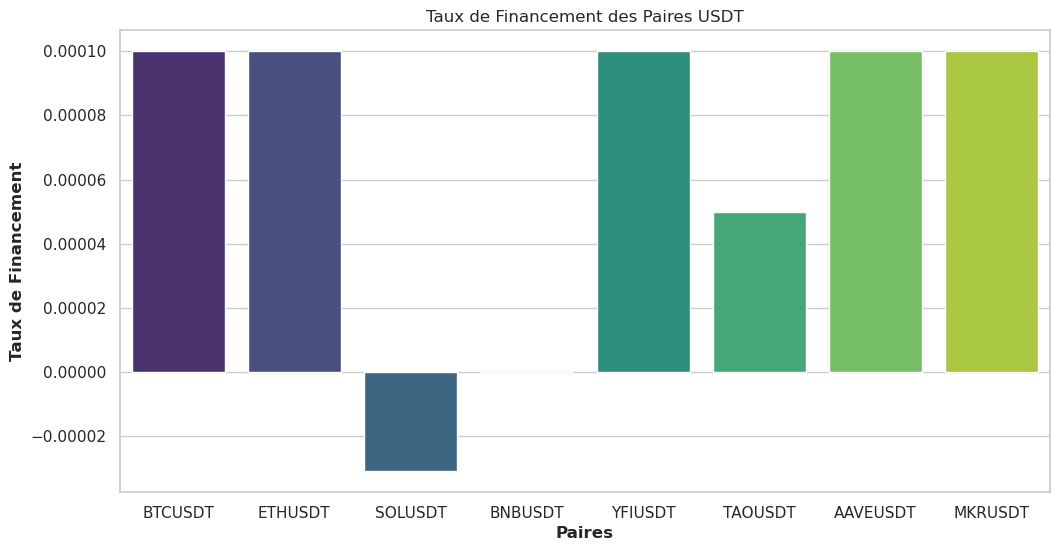

In [54]:
convert_timestamp(funding_rates, 'Funding Time')

# Visualisation des taux de financement
plt.figure(figsize=(12, 6))
sns.barplot(x='Symbol', y='Funding Rate', data=funding_rates, palette='viridis')
plt.title("Taux de Financement des Paires USDT")
plt.xlabel("Paires")
plt.ylabel("Taux de Financement")
plt.show()

# Analyse des statistiques de l'échange

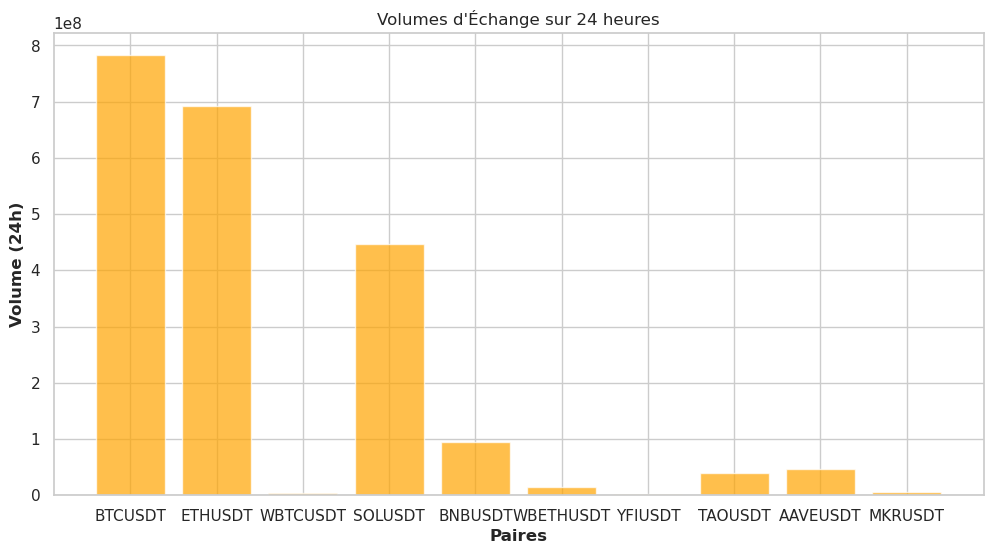

In [55]:
# Visualisation des volumes sur 24 heures
plt.figure(figsize=(12, 6))
plt.bar(exchange_stats['Symbol'], exchange_stats['24h Volume'], color='orange', alpha=0.7)
plt.title("Volumes d'Échange sur 24 heures")
plt.xlabel("Paires")
plt.ylabel("Volume (24h)")
plt.show()

## Analyse des Corrélations
Identification des corrélations entre les paires top 10.

### Matrix

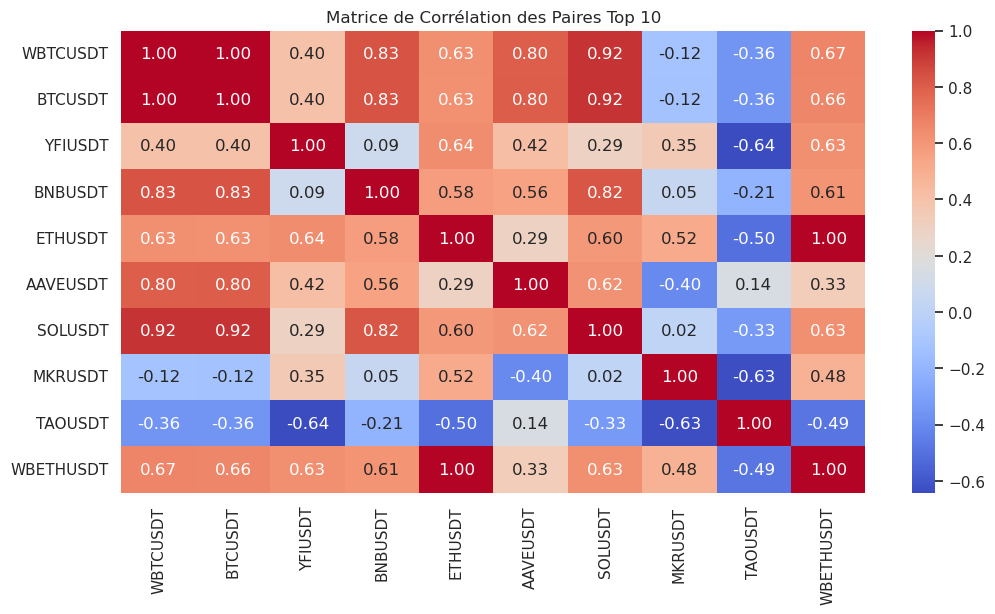

In [56]:

# Visualisation de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation des Paires Top 10")
plt.show()


### Data Connections

In [57]:
# Create a graph from the correlation matrix
G = nx.Graph()

# Define a threshold for correlation to create edges
threshold = 0.5

# Add nodes and edges based on the correlation matrix
for i in correlation_matrix.index:
    G.add_node(i, volume=correlation_matrix.loc[i, i])  # Add volume as a node attribute
    for j in correlation_matrix.columns:
        if i != j and correlation_matrix.loc[i, j] > threshold:
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])

In [58]:
# Set node sizes based on degree centrality
centrality = nx.degree_centrality(G)
node_sizes = [v * 1000 for v in centrality.values()]

# Set edge widths based on correlation weight
edge_widths = [G[u][v]['weight'] * 10 for u, v in G.edges()]

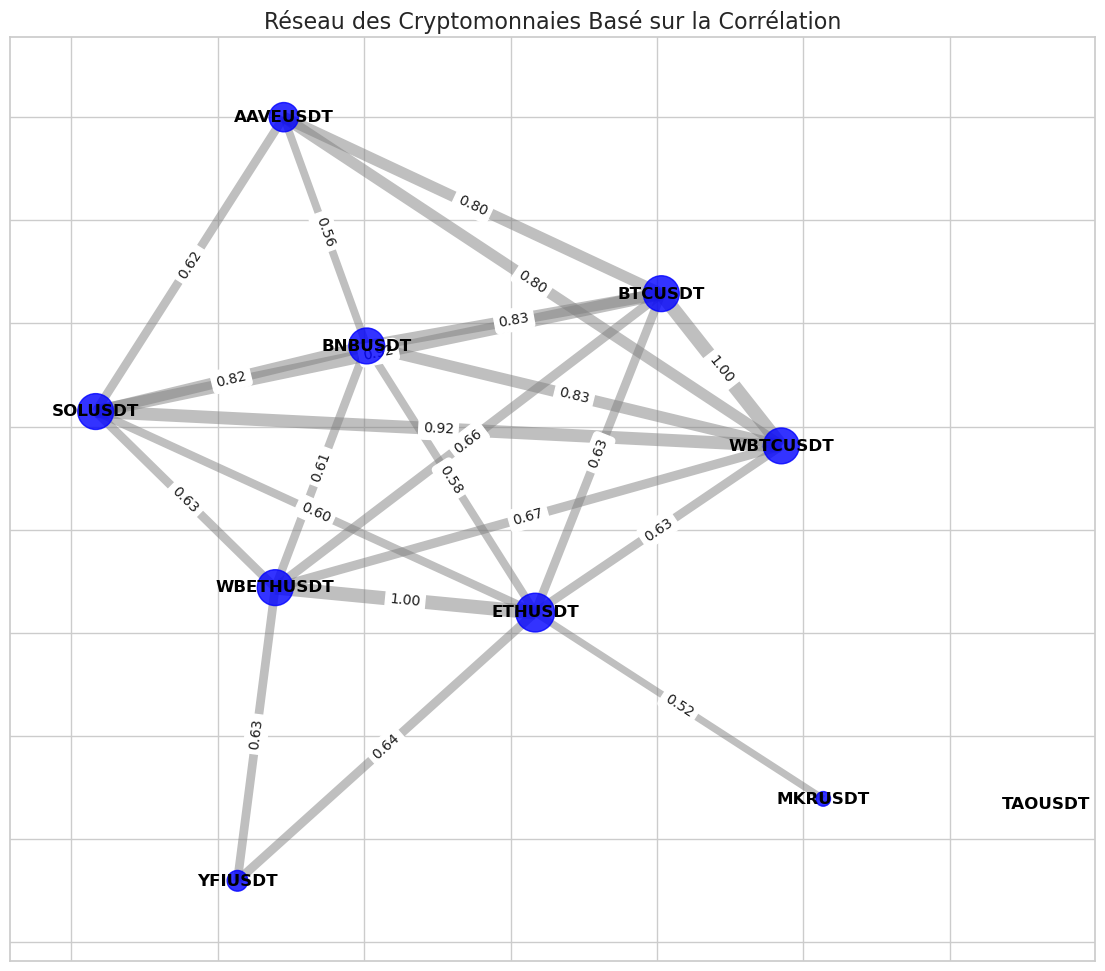

In [59]:
# Position nodes using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Draw the graph
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray')

# Add labels for nodes and edges
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format weights
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_size=10)

# Title
plt.title("Réseau des Cryptomonnaies Basé sur la Corrélation", fontsize=16)
plt.show()


## Analyse de la Volatilité
Calcul de la volatilité historique des paires.

Volatilité quotidienne pour BTCUSDT : 2.76%


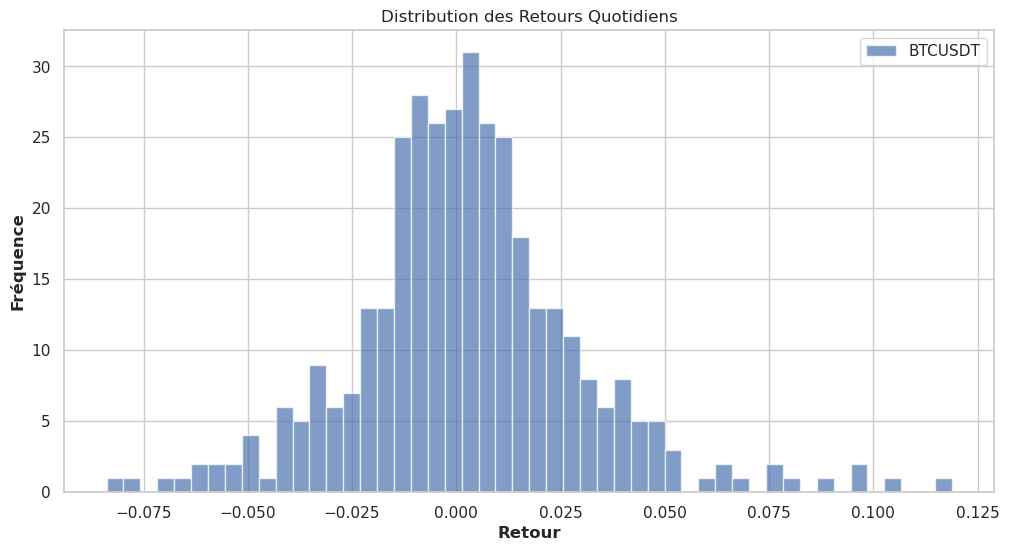

In [60]:

# Calcul de la volatilité quotidienne
btc_historical['Close'] = btc_historical['Close'].astype(float)
btc_historical['Daily Return'] = btc_historical['Close'].pct_change()
volatility = btc_historical['Daily Return'].std()
print(f"Volatilité quotidienne pour BTCUSDT : {volatility:.2%}")

# Visualisation
plt.hist(btc_historical['Daily Return'].dropna(), bins=50, alpha=0.7, label='BTCUSDT')
plt.title("Distribution des Retours Quotidiens")
plt.xlabel("Retour")
plt.ylabel("Fréquence")
plt.legend()
plt.show()


# Analyse des données de contrats à terme (top_10_futures_data.csv)

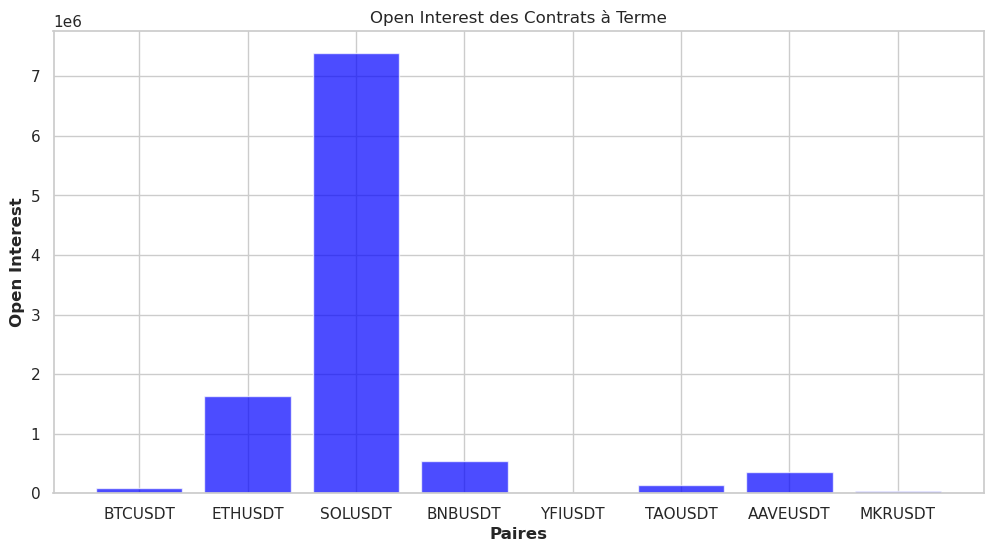

In [61]:
# Visualisation de l'Open Interest par paire
plt.figure(figsize=(12, 6))
plt.bar(futures_data['Symbol'], futures_data['Open Interest'], color='blue', alpha=0.7)
plt.title("Open Interest des Contrats à Terme")
plt.xlabel("Paires")
plt.ylabel("Open Interest")
plt.show()

# Analyse des agrégats de trades

In [62]:
# Force conversion of 'Price' column to numeric
aggregated_trades['Price'] = pd.to_numeric(aggregated_trades['Price'], errors='coerce')

# Drop NaN values resulting from conversion
aggregated_trades = aggregated_trades.dropna(subset=['Price'])

# Ensure no infinite or extremely small/large values
aggregated_trades = aggregated_trades[(aggregated_trades['Price'] > 0) & (aggregated_trades['Price'] < 1e10)]


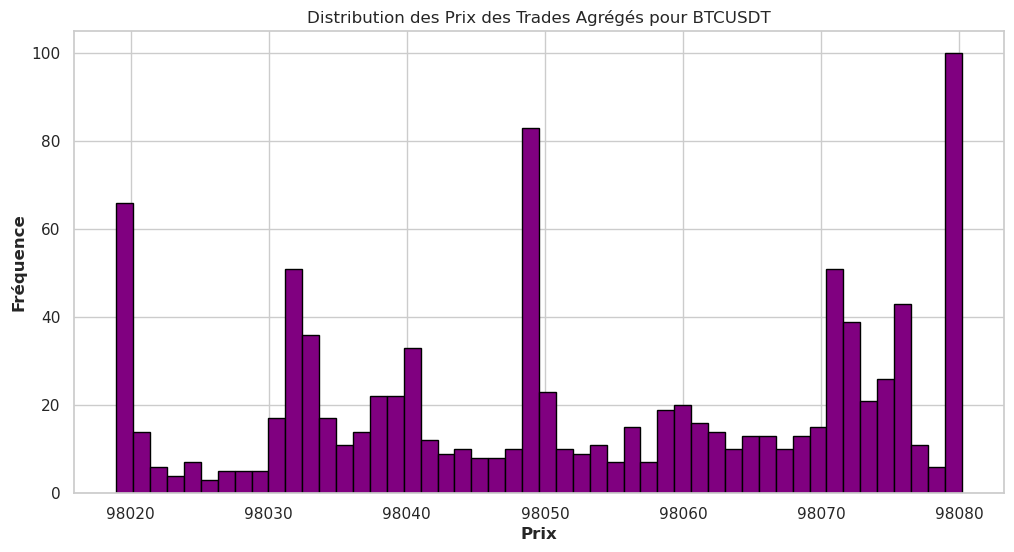

In [63]:
# Visualization of the distribution of trade prices
plt.figure(figsize=(12, 6))
plt.hist(aggregated_trades['Price'], bins=50, color='purple', edgecolor='black')
plt.title("Distribution des Prix des Trades Agrégés pour BTCUSDT")
plt.xlabel("Prix")
plt.ylabel("Fréquence")
plt.show()


## Tendance des Volumes Historiques
Analyse des volumes de trading au fil du temps.

### Bitcoin

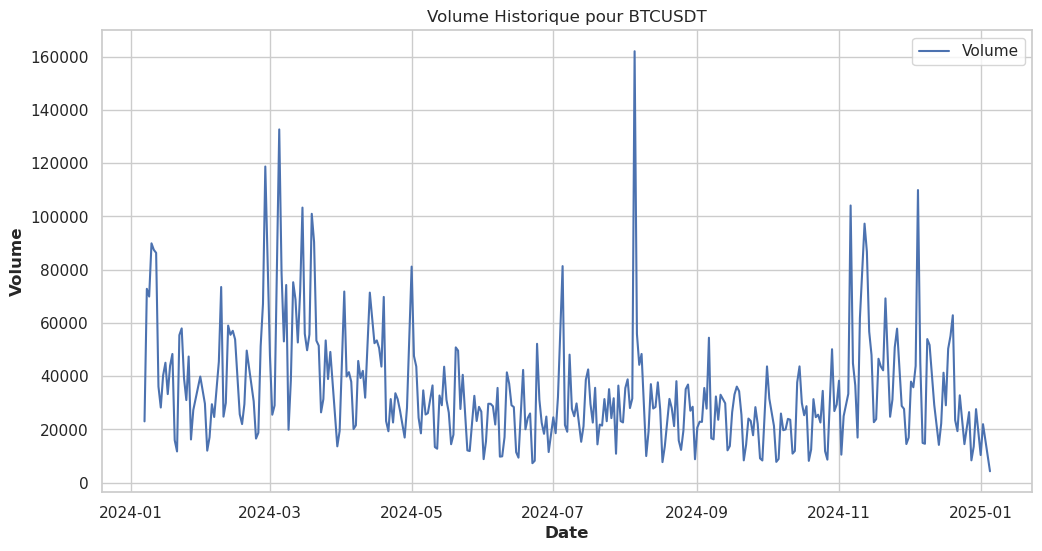

In [64]:
# Conversion des colonnes appropriées
btc_historical['Timestamp'] = pd.to_datetime(btc_historical['Timestamp'], unit='ms')
btc_historical['Volume'] = pd.to_numeric(btc_historical['Volume'], errors='coerce')

# Vérification et suppression des valeurs nulles
btc_historical = btc_historical.dropna(subset=['Volume'])

# Assurez-vous que 'Volume' est une série unidimensionnelle
if len(btc_historical['Volume'].shape) > 1:
    btc_historical['Volume'] = btc_historical['Volume'].squeeze()

# Visualisation des volumes
plt.plot(btc_historical['Timestamp'].values, btc_historical['Volume'].values, label='Volume')
plt.title("Volume Historique pour BTCUSDT")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


### All pairs (tt les top 10 cryptoCoins)

In [65]:
# Path to the folder containing the historical trade files
folder_path = "data/binance/top_10"

# Initialize a dictionary to store data for each symbol
historical_data = {}

# Load and process each file
for file_name in os.listdir(folder_path):
    if file_name.endswith("_history_last_year.csv"):  # Ensure only historical files are processed
        symbol = file_name.split("_")[0]  # Extract symbol from the filename
        file_path = os.path.join(folder_path, file_name)
        
        # Load the CSV file
        data = pd.read_csv(file_path)
        
        # Ensure required columns are present
        required_columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        if all(col in data.columns for col in required_columns):
            # Convert 'Timestamp' to datetime and other columns to numeric
            data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms', errors='coerce')
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            
            # Drop rows with missing values
            data = data.dropna(subset=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
            
            # Store the processed data in the dictionary
            historical_data[symbol] = data

### Tendance des Volumes

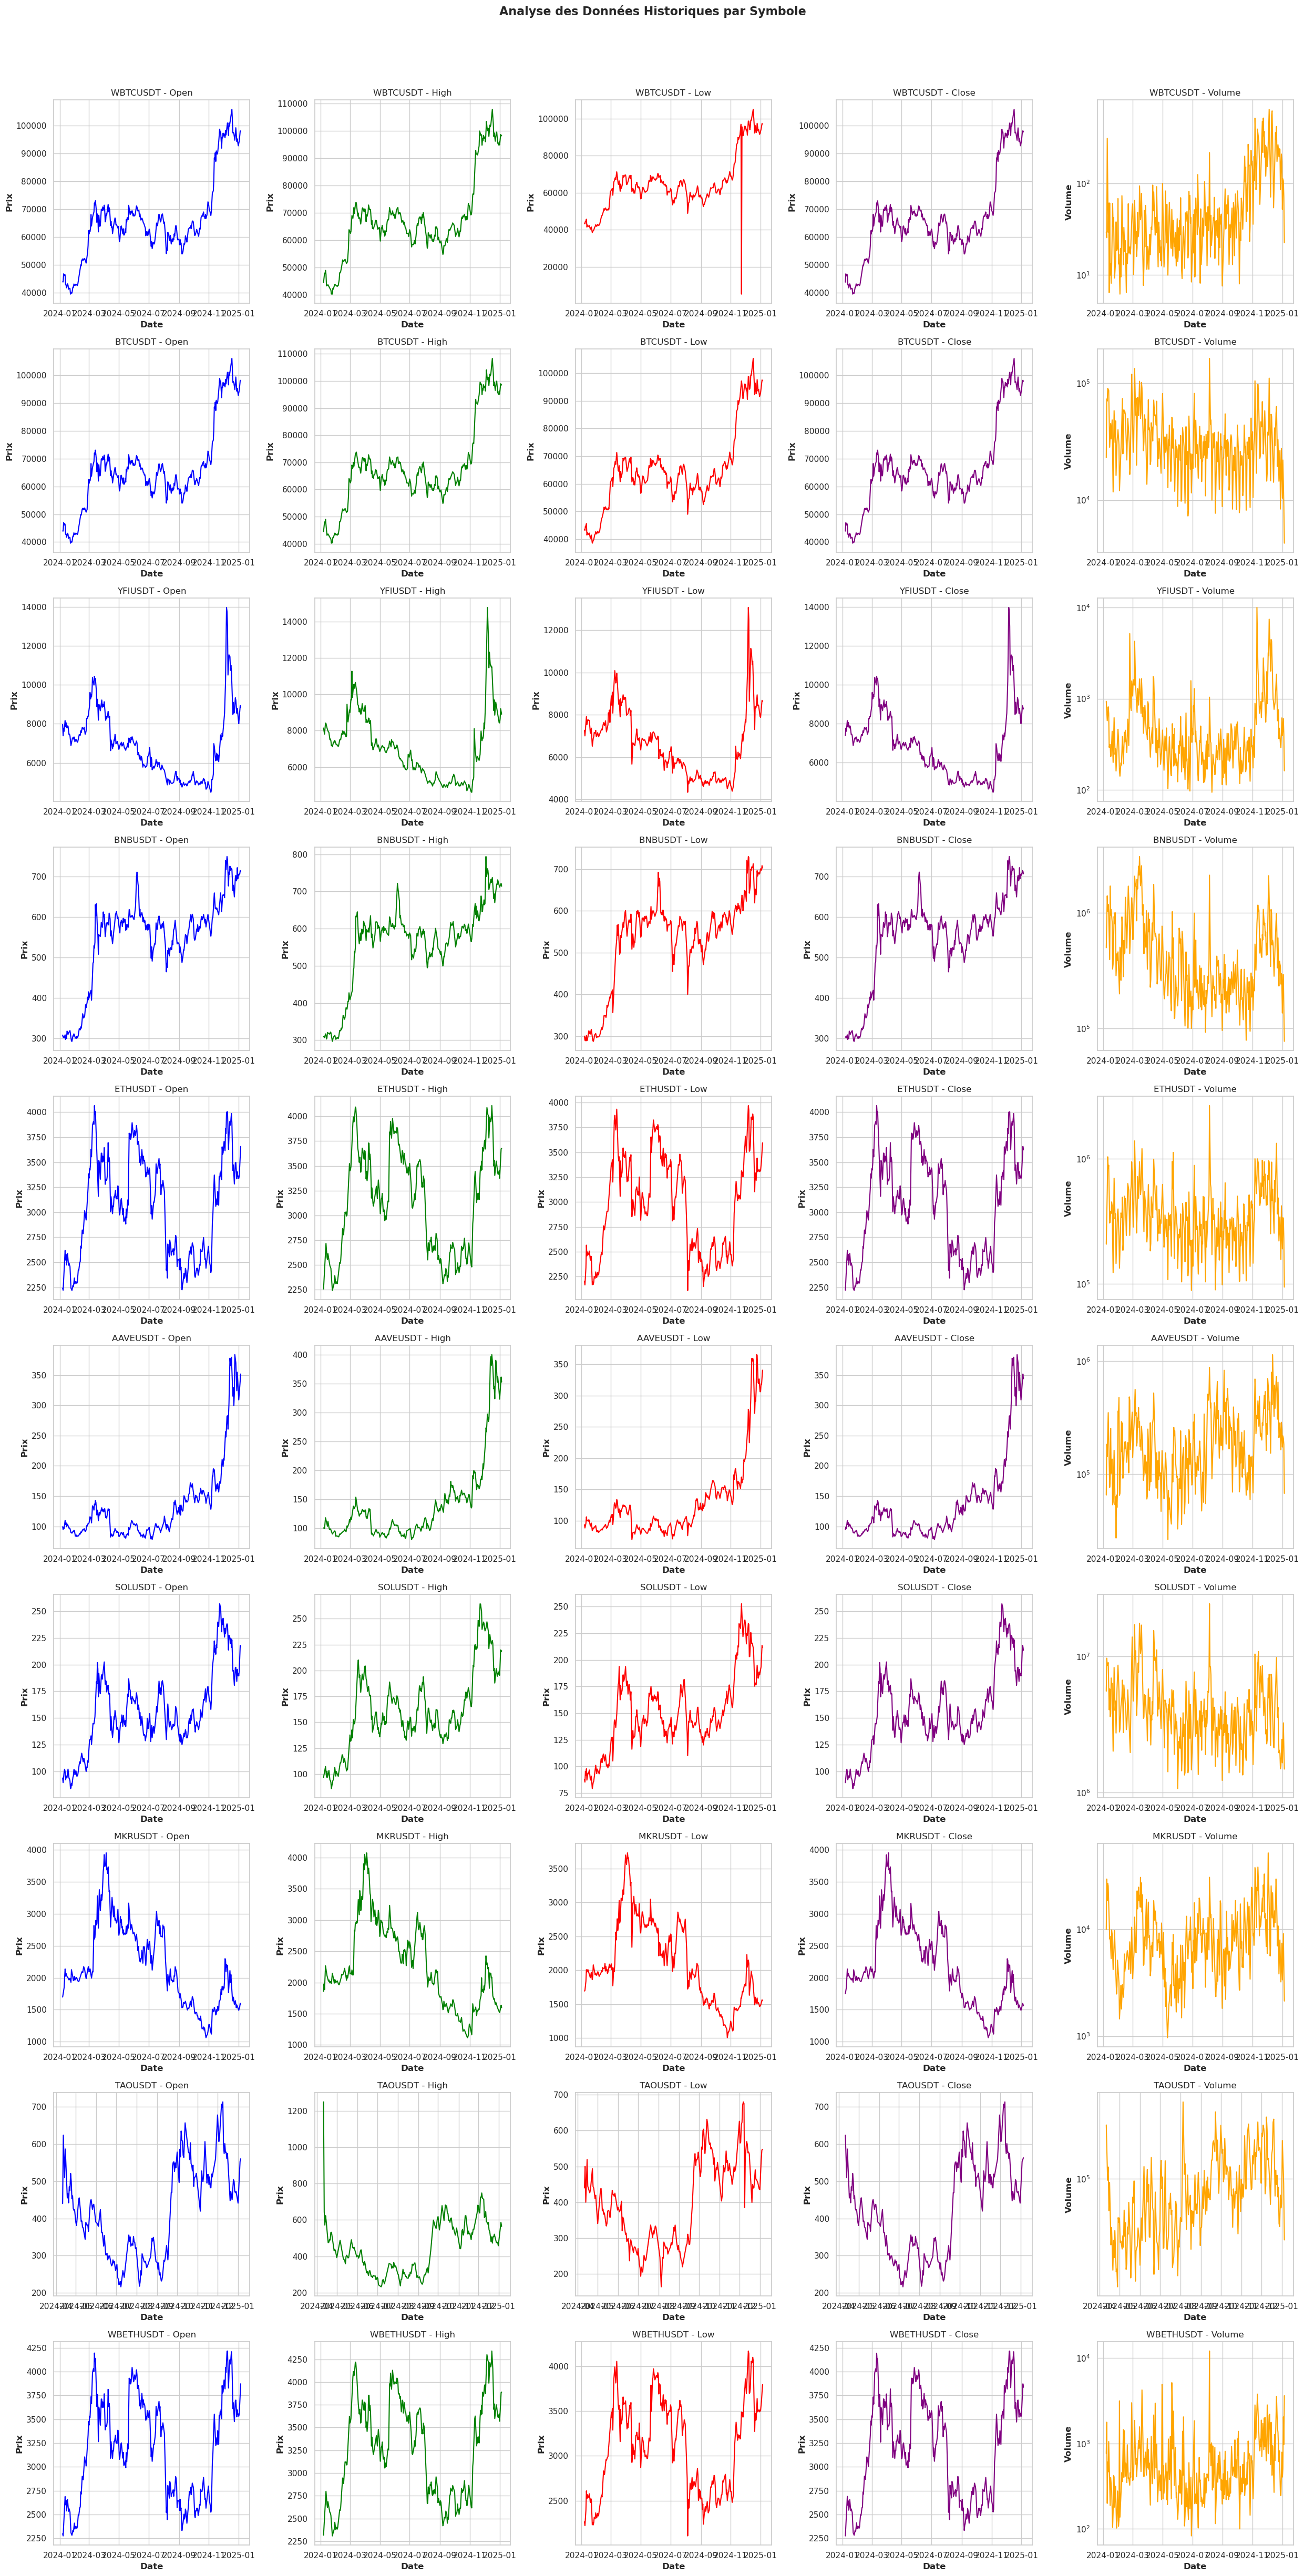

In [66]:
# Generate plots for all attributes
fig, axs = plt.subplots(len(historical_data), 5, figsize=(25, 5 * len(historical_data)))
fig.suptitle("Analyse des Données Historiques par Symbole", fontsize=16)

for idx, (symbol, data) in enumerate(historical_data.items()):
    # Ensure columns are valid and one-dimensional
    if not data.empty and all(col in data.columns for col in ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']):
        timestamps = data['Timestamp'].values.flatten()  # Ensure one-dimensional
        opens = data['Open'].values.flatten()
        highs = data['High'].values.flatten()
        lows = data['Low'].values.flatten()
        closes = data['Close'].values.flatten()
        volumes = data['Volume'].values.flatten()

        # Plot Open prices
        axs[idx, 0].plot(timestamps, opens, label=f"{symbol} - Open", color='blue')
        axs[idx, 0].set_title(f"{symbol} - Open")
        axs[idx, 0].set_xlabel("Date")
        axs[idx, 0].set_ylabel("Prix")
        axs[idx, 0].grid(True)

        # Plot High prices
        axs[idx, 1].plot(timestamps, highs, label=f"{symbol} - High", color='green')
        axs[idx, 1].set_title(f"{symbol} - High")
        axs[idx, 1].set_xlabel("Date")
        axs[idx, 1].set_ylabel("Prix")
        axs[idx, 1].grid(True)

        # Plot Low prices
        axs[idx, 2].plot(timestamps, lows, label=f"{symbol} - Low", color='red')
        axs[idx, 2].set_title(f"{symbol} - Low")
        axs[idx, 2].set_xlabel("Date")
        axs[idx, 2].set_ylabel("Prix")
        axs[idx, 2].grid(True)

        # Plot Close prices
        axs[idx, 3].plot(timestamps, closes, label=f"{symbol} - Close", color='purple')
        axs[idx, 3].set_title(f"{symbol} - Close")
        axs[idx, 3].set_xlabel("Date")
        axs[idx, 3].set_ylabel("Prix")
        axs[idx, 3].grid(True)

        # Plot Volumes with logarithmic scale
        axs[idx, 4].plot(timestamps, volumes, label=f"{symbol} - Volume", color='orange')
        axs[idx, 4].set_yscale('log')
        axs[idx, 4].set_title(f"{symbol} - Volume")
        axs[idx, 4].set_xlabel("Date")
        axs[idx, 4].set_ylabel("Volume")
        axs[idx, 4].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Kline Data Analysis

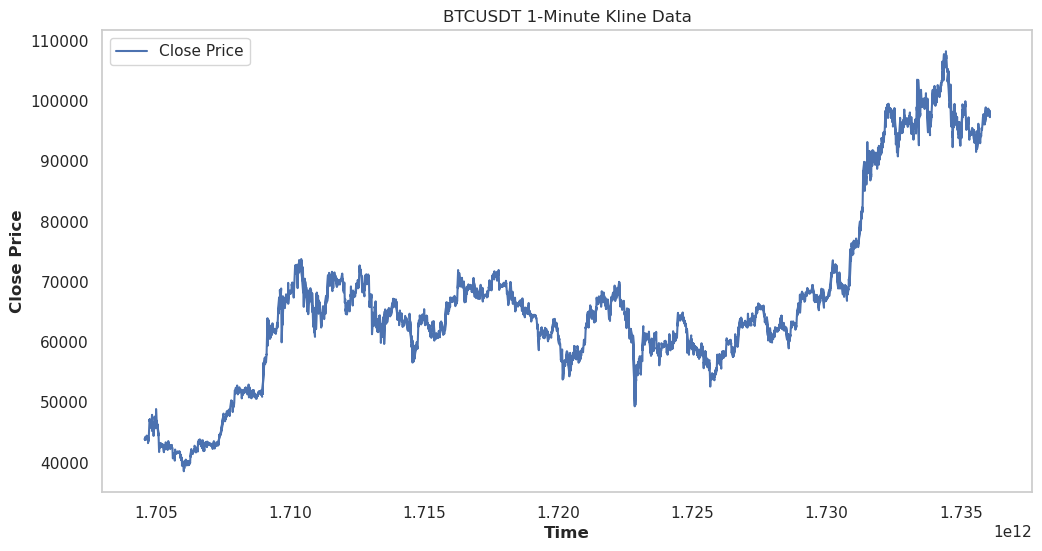

In [67]:
timestamps = btc_kline['Timestamp'].values
close_prices = btc_kline['Close'].values

plt.figure(figsize=(12, 6))
plt.plot(timestamps, close_prices, label="Close Price")
plt.title("BTCUSDT 1-Minute Kline Data")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


In [68]:
# Path to the folder containing Kline data files
folder_path = "data/binance/top_10_kline_granular"

# Initialize a dictionary to store Kline data for each symbol
kline_data = {}

# Dynamically load Kline data
for file_name in os.listdir(folder_path):
    if file_name.endswith("_kline.csv"):  # Ensure only Kline files are processed
        parts = file_name.split("_")
        symbol = parts[0]  # Extract the symbol (e.g., BTCUSDT)
        interval = parts[1]  # Extract the interval (e.g., 1m, 1h, 4h)
        
        file_path = os.path.join(folder_path, file_name)
        
        # Load the CSV file
        data = pd.read_csv(file_path)
        
        # Ensure required columns are present
        if all(col in data.columns for col in ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']):
            # Process data
            data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms', errors='coerce')
            data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
            data['High'] = pd.to_numeric(data['High'], errors='coerce')
            data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
            data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
            data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')
            data = data.dropna(subset=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

            # Organize data by symbol and interval
            if symbol not in kline_data:
                kline_data[symbol] = {}
            kline_data[symbol][interval] = data

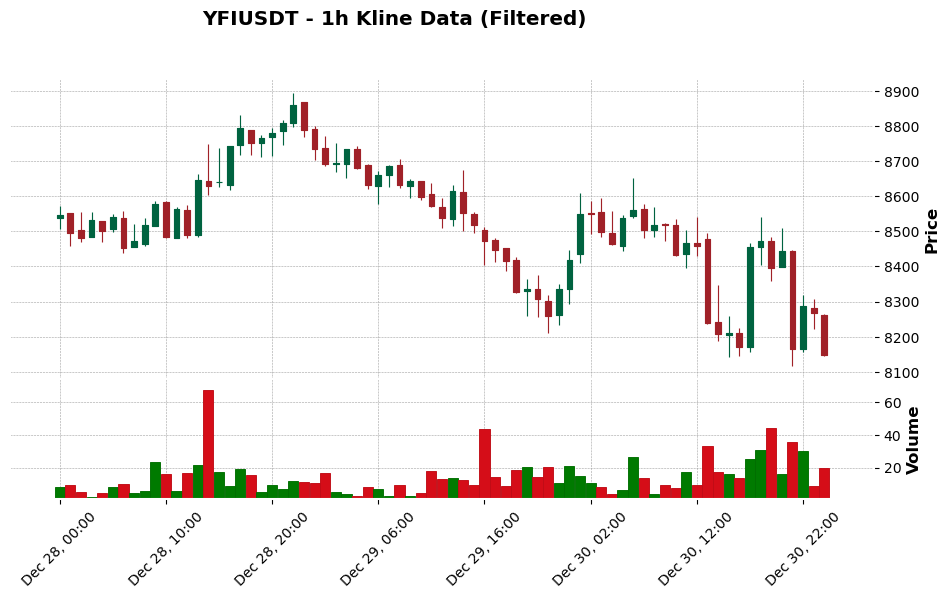

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


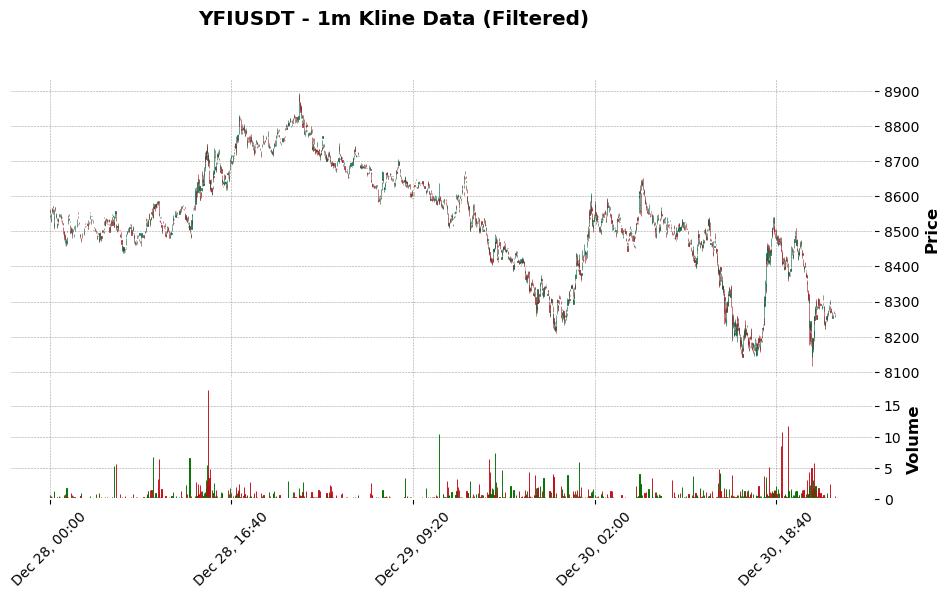

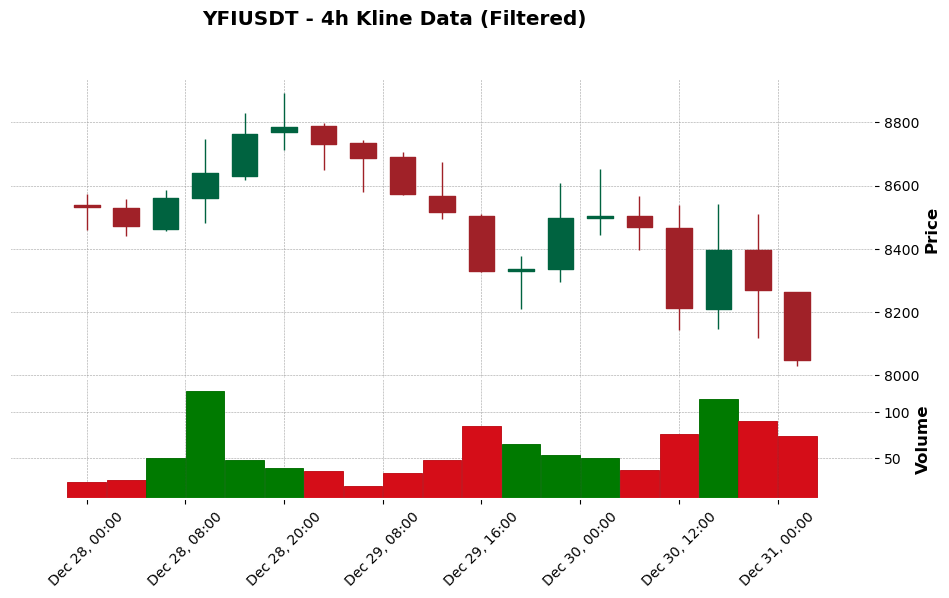

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


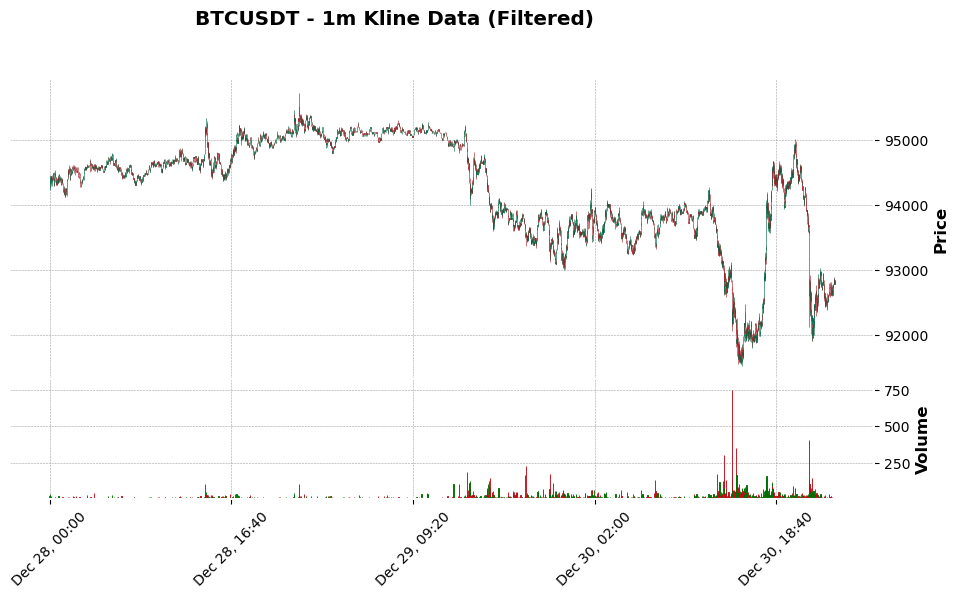

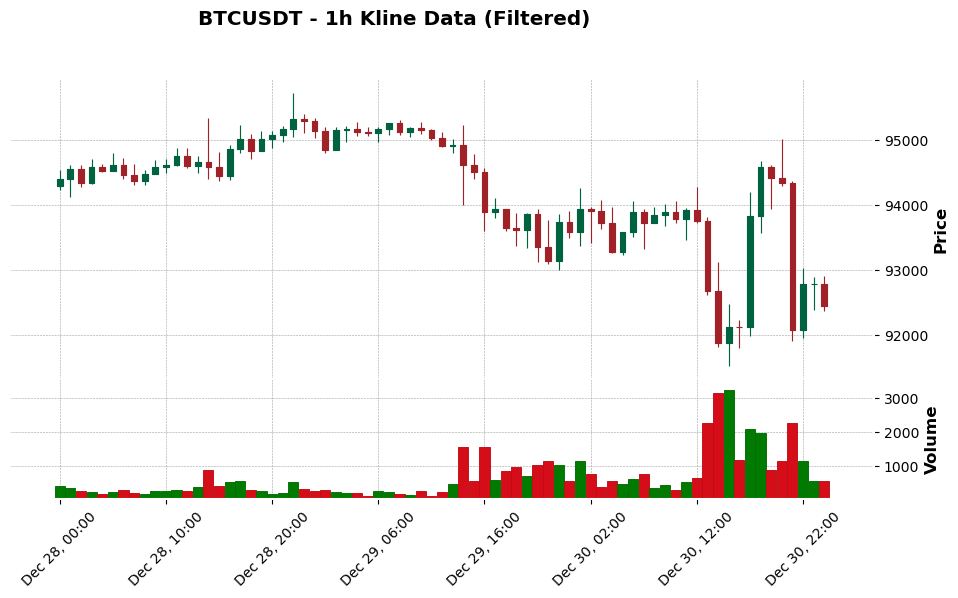

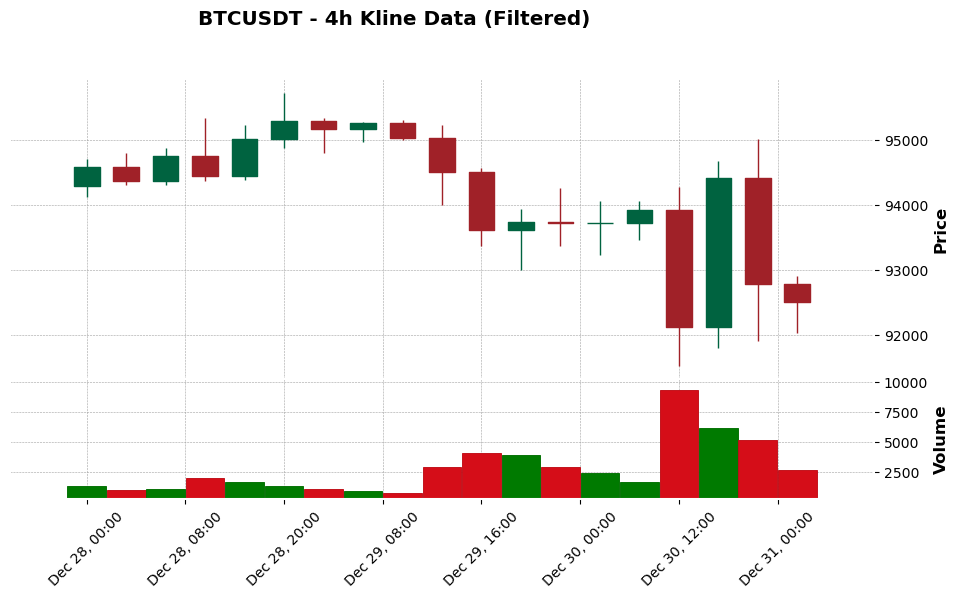

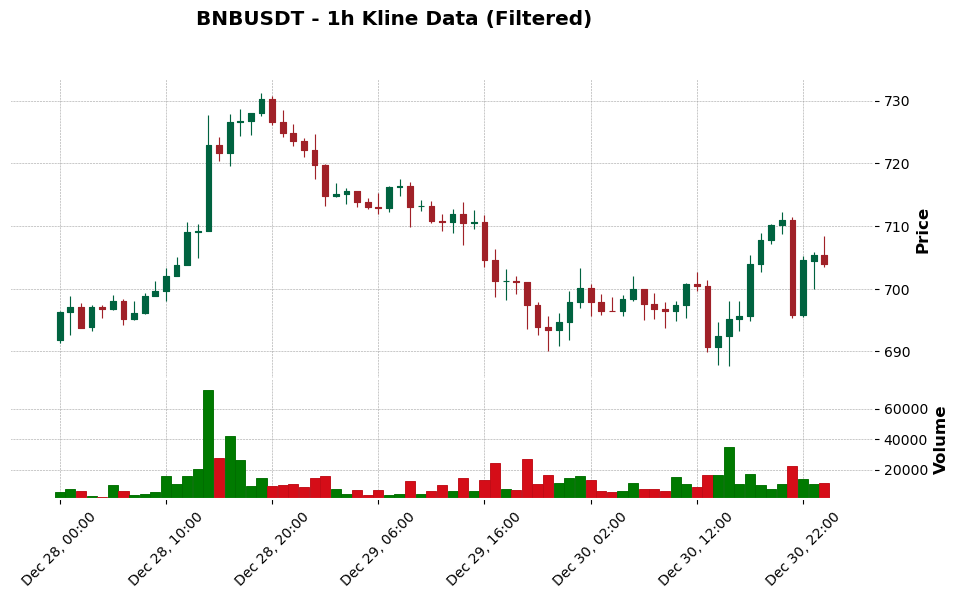

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


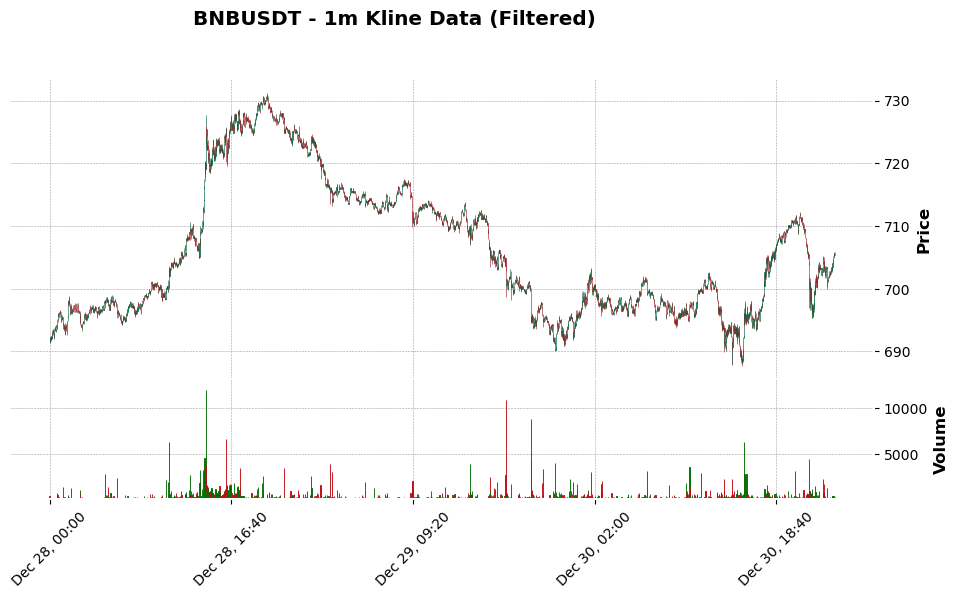

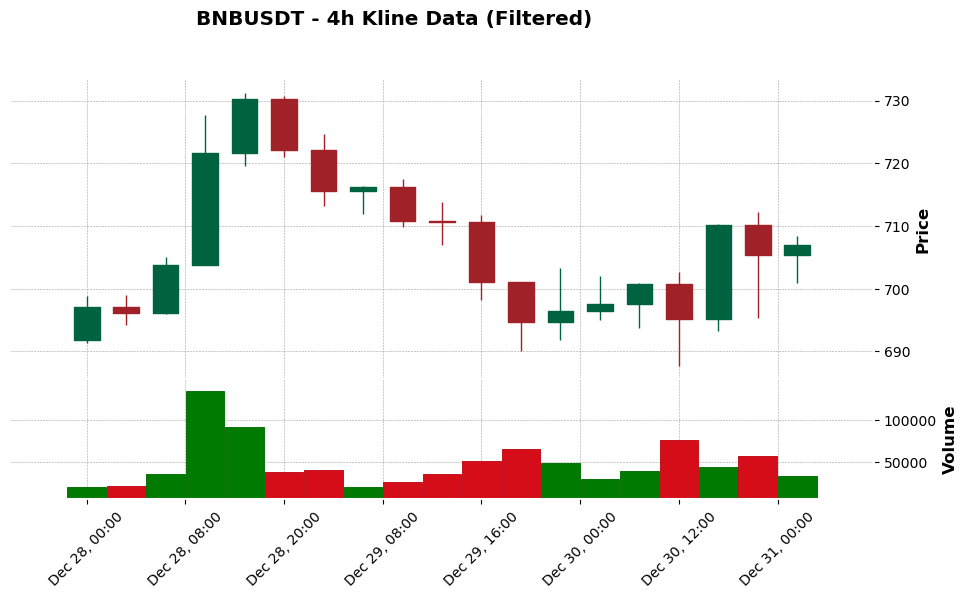

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


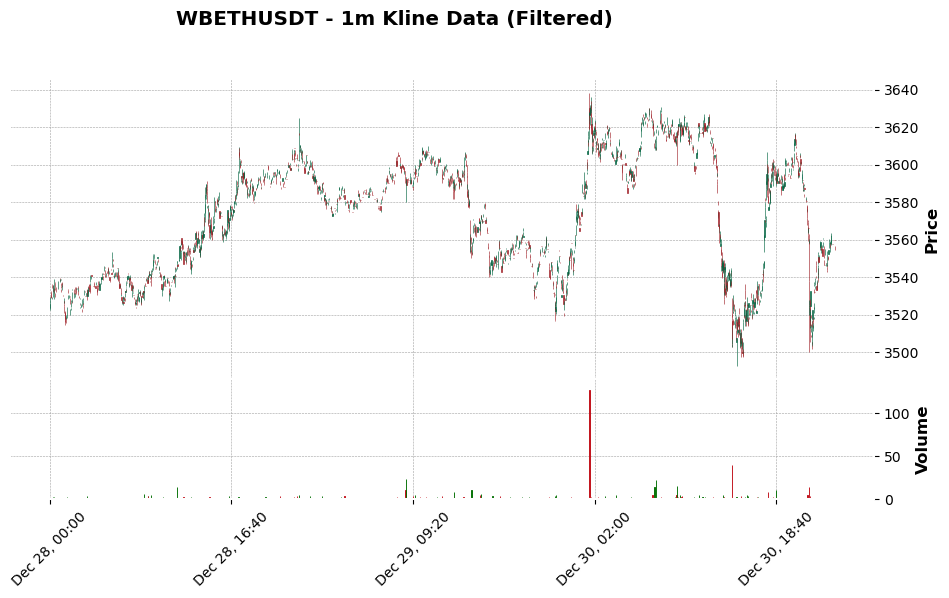

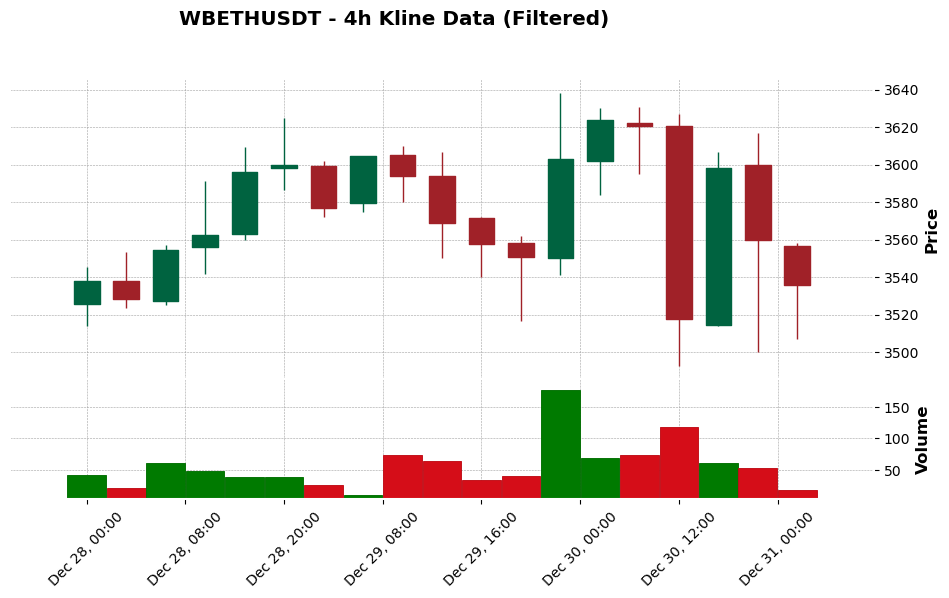

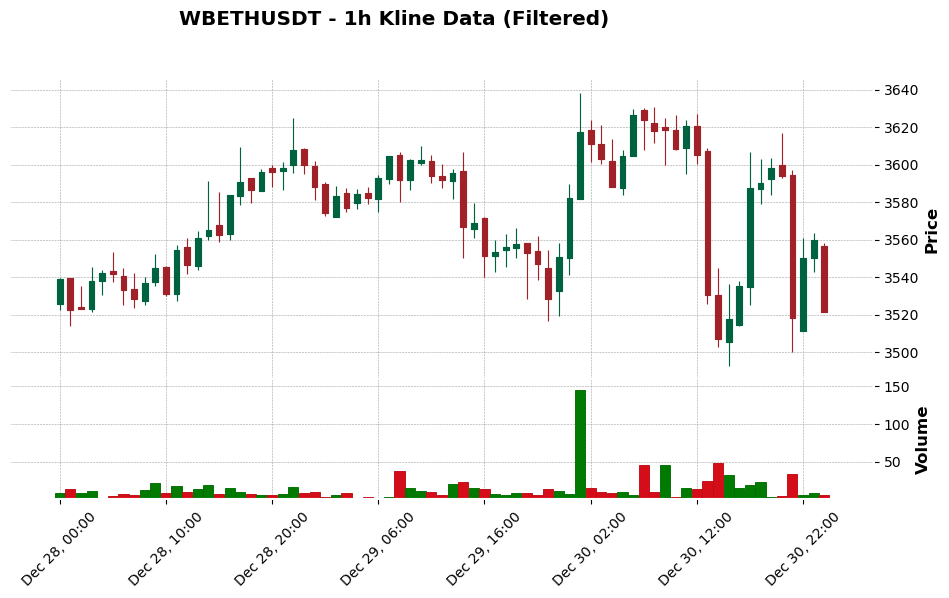

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


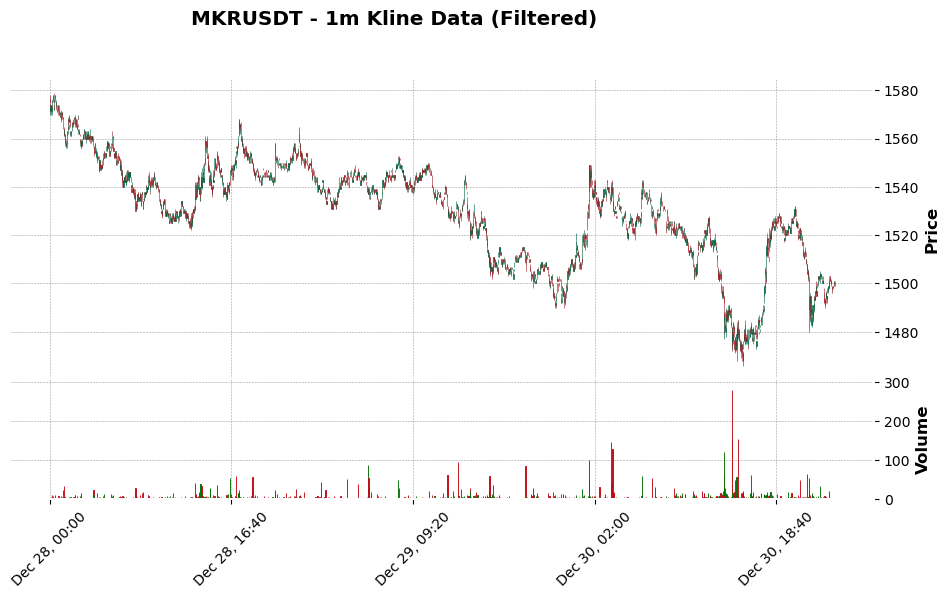

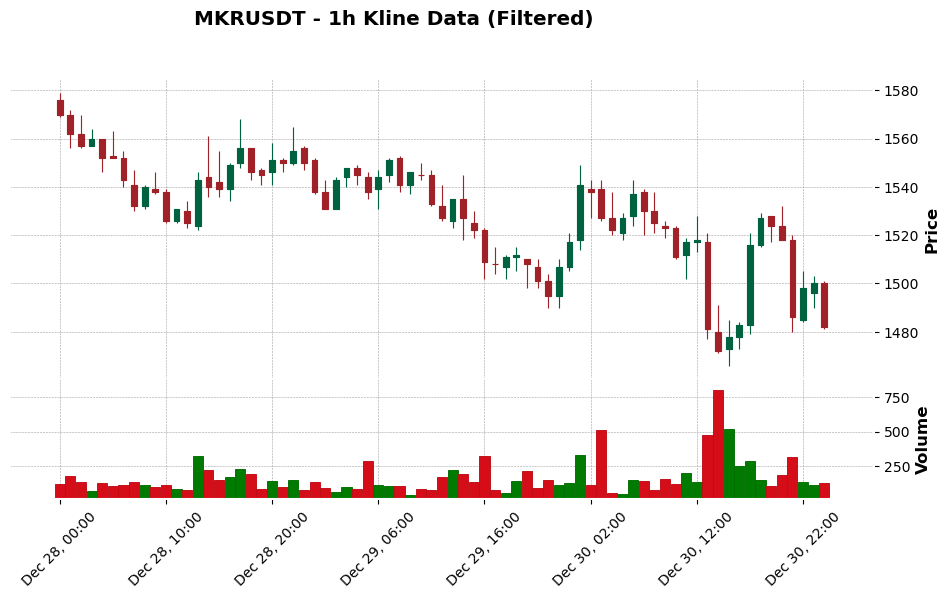

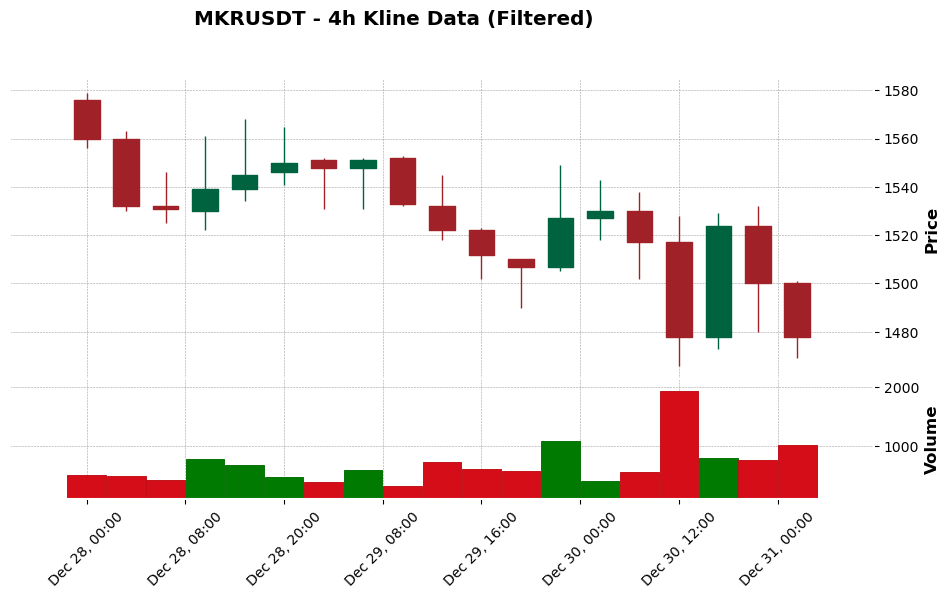

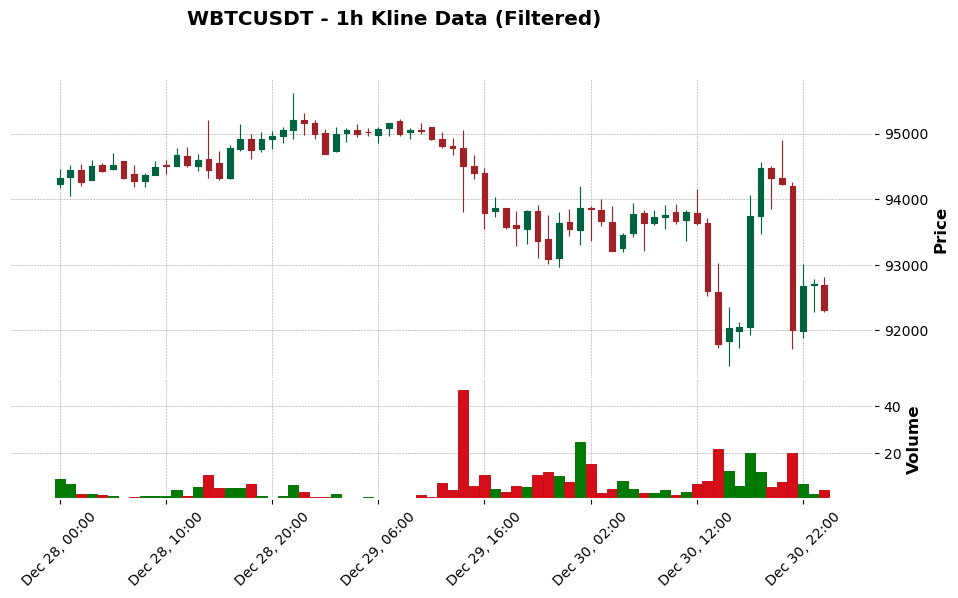

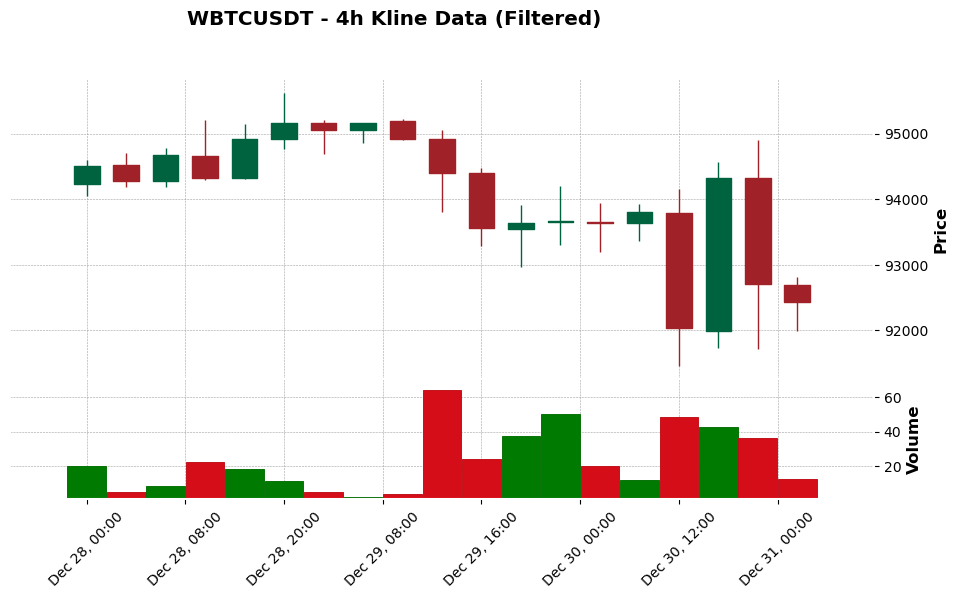

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


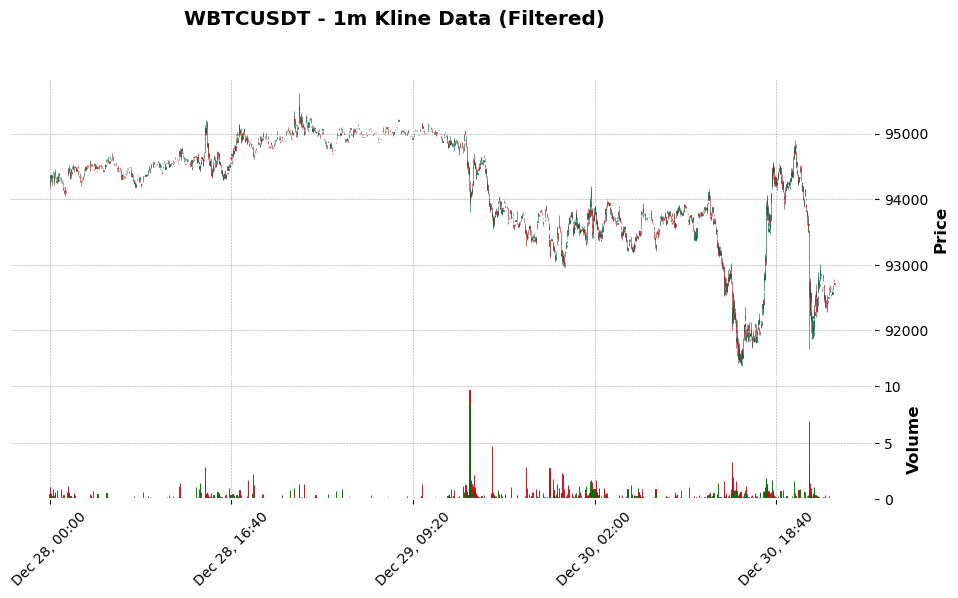

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


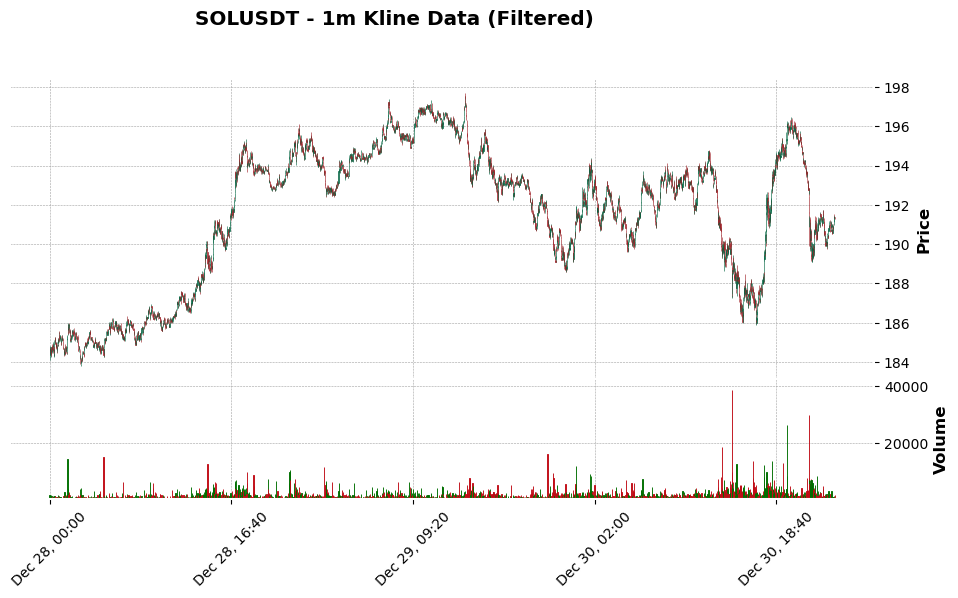

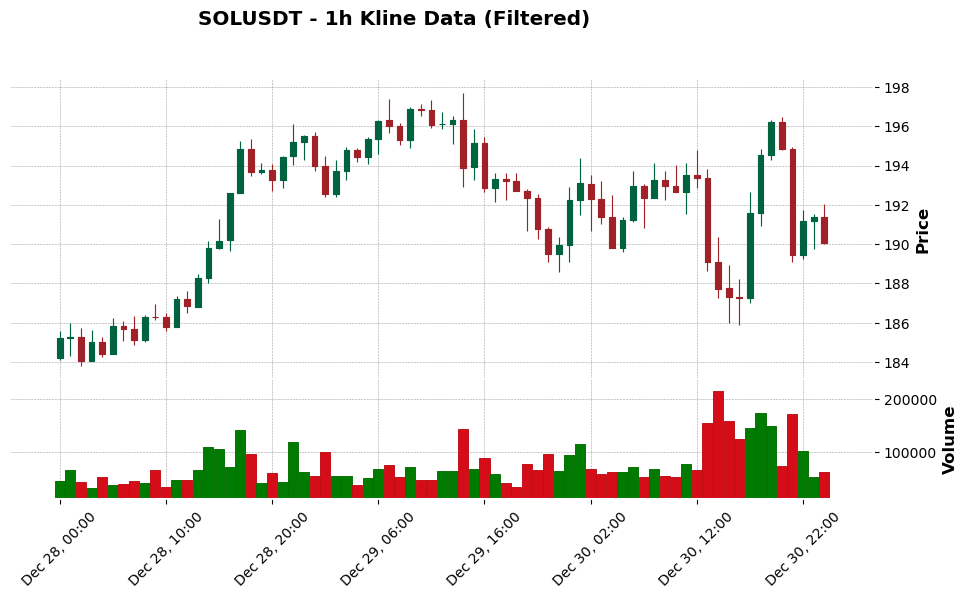

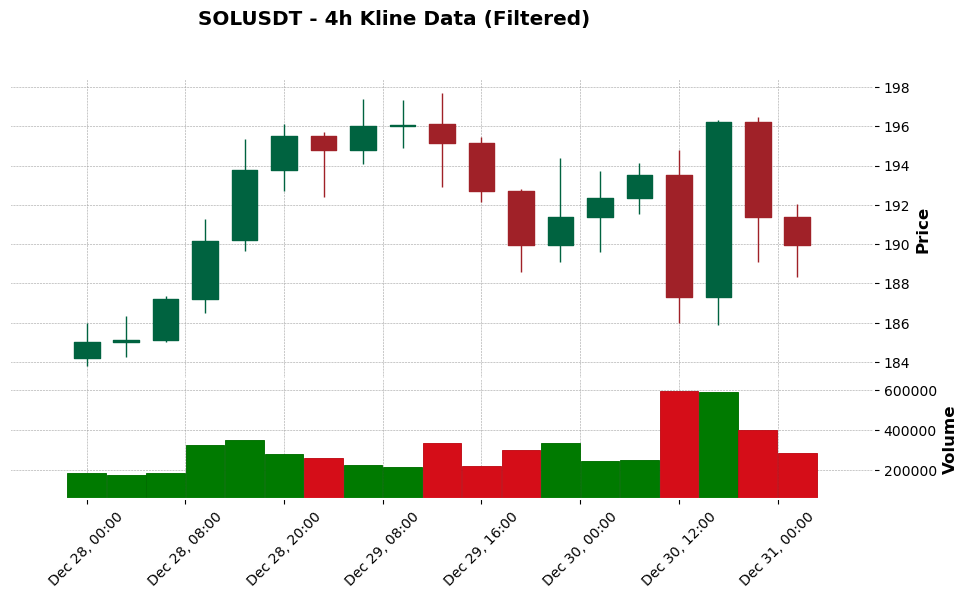

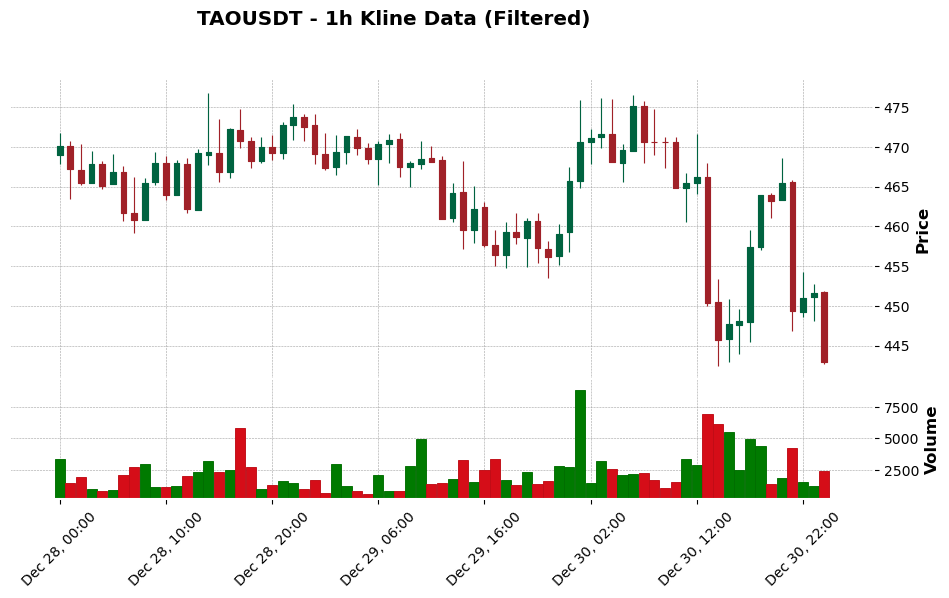

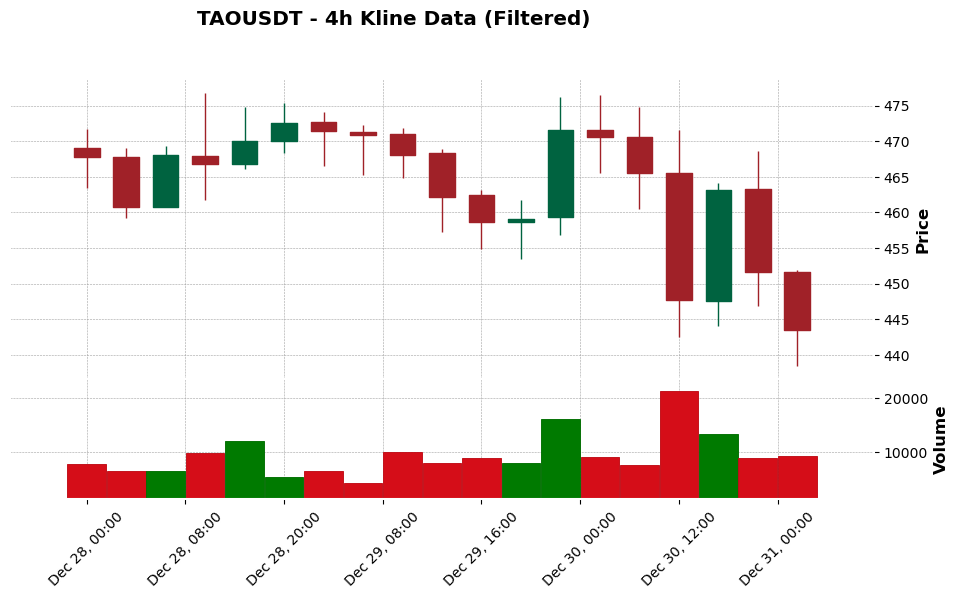

/home/abdennacer/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


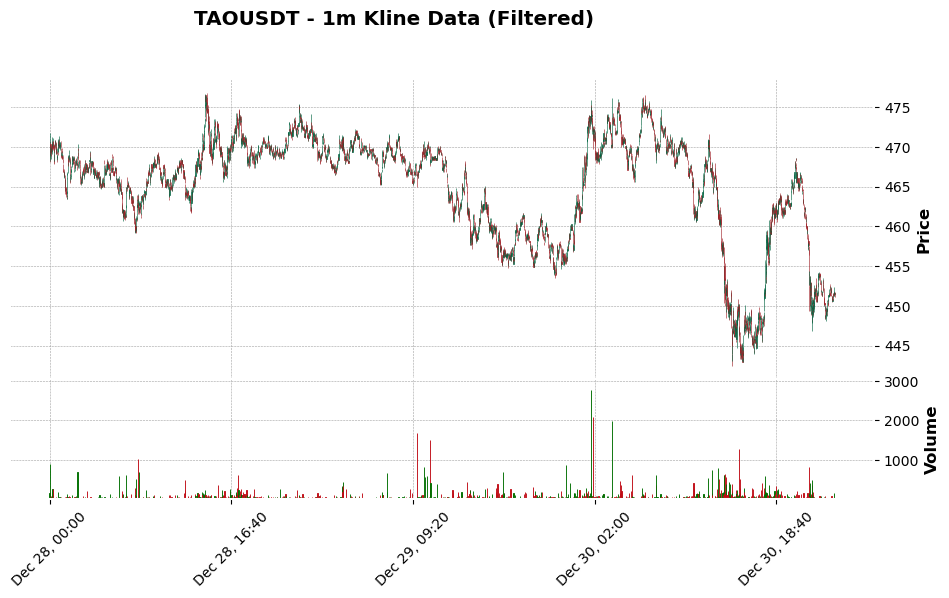

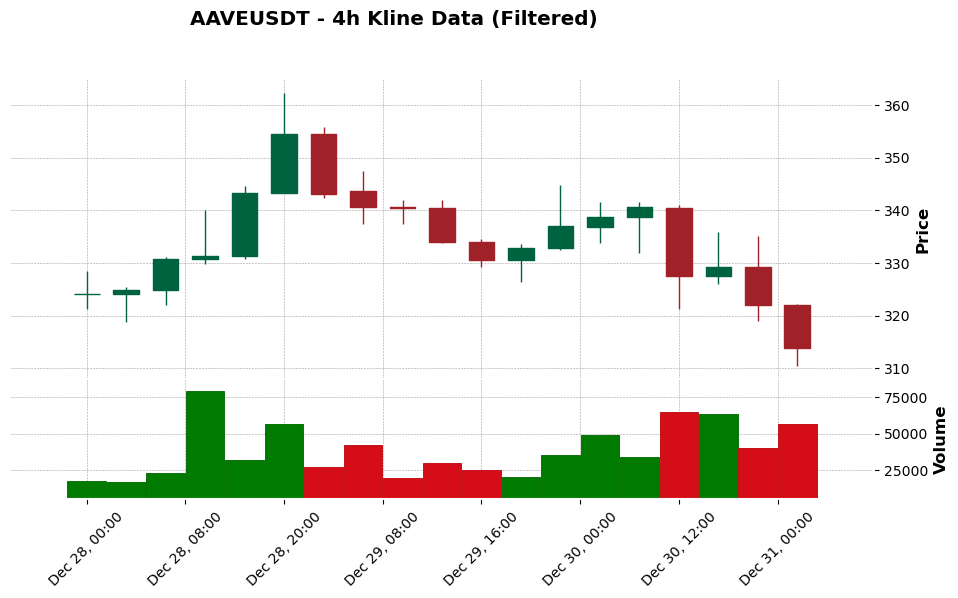

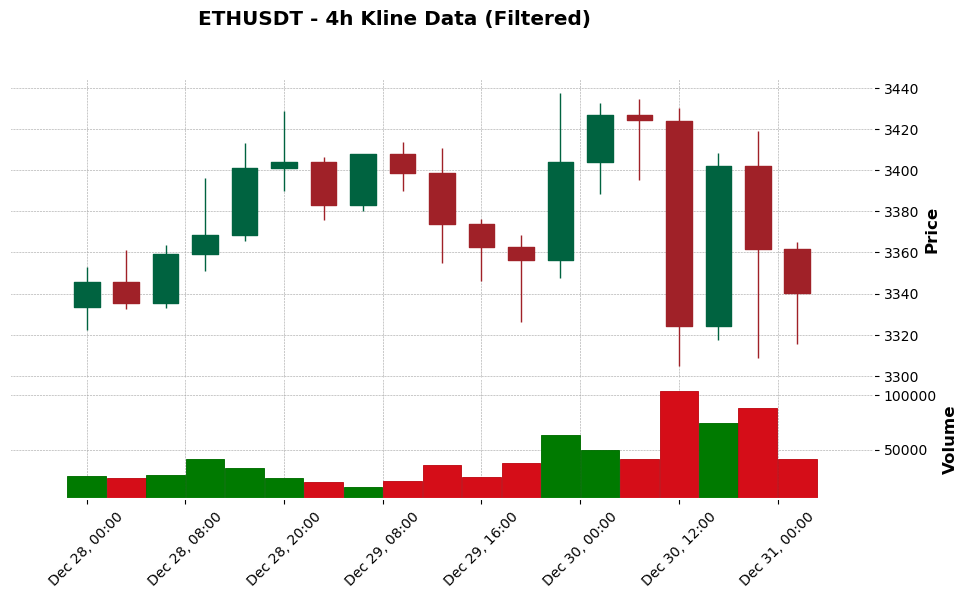

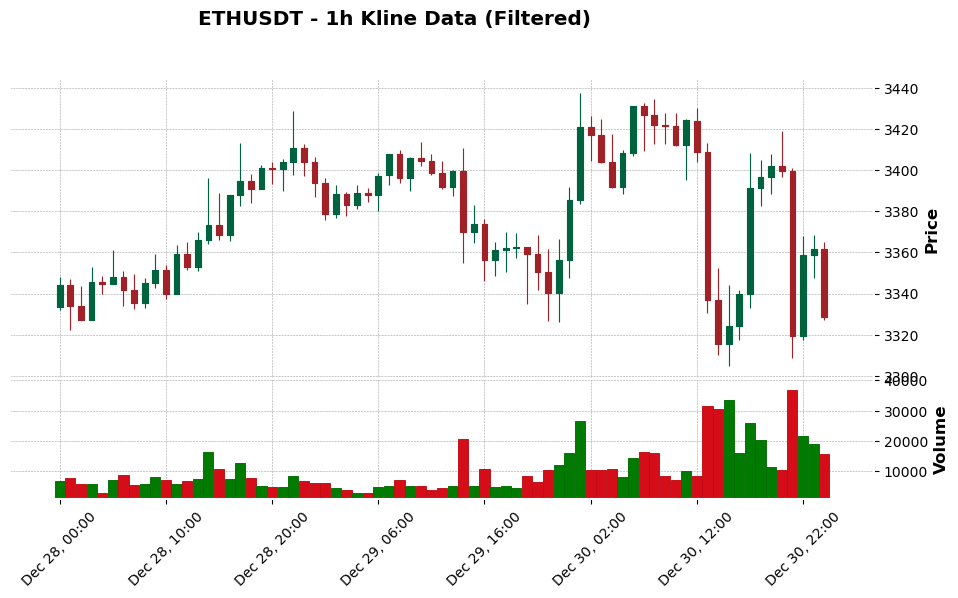

In [69]:
# Define the range of dates to visualize (as timestamps)
start_date = pd.Timestamp("2024-12-28")
end_date = pd.Timestamp("2024-12-31")

# Visualize Kline data for each symbol and interval using candlestick charts
for symbol, intervals in kline_data.items():
    for interval, data in intervals.items():
        # Filter data based on the selected date range
        filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]
        
        # If no data exists in the filtered range, skip plotting
        if filtered_data.empty:
            print(f"No data for {symbol} - {interval} in the selected range.")
            continue

        # Prepare the data for mplfinance
        filtered_data.set_index('Timestamp', inplace=True)  # Set the timestamp as the index
        ohlcv_data = filtered_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Select relevant columns

        # Plot the candlestick chart
        mpf.plot(
            ohlcv_data,
            type='candle',  # Use candlestick chart
            style='charles',  # Chart style
            volume=True,  # Add volume bars
            title=f"{symbol} - {interval} Kline Data (Filtered)",
            ylabel="Price",
            ylabel_lower="Volume",
            figsize=(12, 6)
        )